## Neural Networks with R Torch

In this session, we’ll dive into the fundamentals of neural networks, exploring how these models work and how they can be applied to complex data analytics tasks. Neural networks have transformed the field of machine learning, allowing us to uncover patterns and make predictions in ways that traditional models cannot.

This tutorial will focus on building, training, and evaluating a simple neural network in R, using the torch package. torchis a powerful and flexible package for deep learning, and it allows us to implement neural networks in R with ease. By the end of this tutorial, you will have hands-on experience creating a neural network from scratch, training it with real data, and evaluating its performance.

### Lab Outline

1. Introduction to the torch Package in R

- Installation and setting up torch in R
- Core concepts in Torch: Tensors, Autograd, Device, and Modules
- Components of a Neural Network

2. Understanding and defining the structure of the neural network in R

- Defining components of the model: Loss Function, Optimizer, Activation Function, Architecture
- Implementing a Neural Network on Sample Data

3. Building a Neural Network from Scratch

- Understanding Infrastructure of the Neural Network - Layers and Activation Functions
- Training and Testing through Epochs - model$eval and model$train

4. Visualizing Training and Test Losses


### Let’s Begin!

Before diving into neural networks, let's make sure we have all the necessary packages installed and set up. The torch package is the primary tool we'll use to build and train our neural networks in R, and torchvision provides additional utilities for working with image data. The luz package adds useful high-level abstractions for managing models, such as training loops, making it easier to work with neural networks in torch.

### Installation Notes

__torch__: The core deep learning library for R, allowing us to define and train neural networks with GPU support. <br>
__torchvision__: Provides utilities for loading and processing image data, plus pre-trained models for computer vision tasks (optional but helpful if you plan to work with image data). <br>
__luz__: Simplifies model training with higher-level abstractions, including automated training loops, validation, and hyperparameter tuning. <br>

Uncomment the installation commands below if you haven’t already installed these packages. Note: Some of these packages may require additional dependencies. Make sure your R environment is up to date.



In [3]:
# installing the packages
#install.packages(c("torch", "torchvision", "luz"))
#devtools::install_github("mlverse/torch")
#devtools::install_github("mlverse/torchvision")

## Core Concepts in Torch

To effectively work with neural networks in R using the torch package, it's essential to understand some core concepts: Tensors, Modules, and Autograd. These components provide the foundational tools for creating and training neural networks, handling data, and calculating gradients.

### 1. Tensors

Tensors are the primary data structure in torch. They are multi-dimensional arrays (similar to matrices) and serve as the basic building block for neural networks. Tensors can hold data of various types (integers, floats, etc.) and can be one-dimensional (vectors), two-dimensional (matrices), or higher-dimensional.

Here’s a quick example to create and manipulate tensors in torch.

In [4]:
library(torch)
library(torchvision)
library(ggplot2)
library(coro)
library(luz)

# Create a 1D tensor
tensor_1d <- torch_tensor(c(1, 2, 3, 4, 5))
print(tensor_1d)

# Create a 2D tensor (matrix)
tensor_2d <- torch_tensor(matrix(1:9, nrow = 3, ncol = 3))
print(tensor_2d)

# Tensor operations (e.g., addition)
tensor_sum <- tensor_1d + tensor_1d
print(tensor_sum)

i Additional software needs to be downloaded and installed for torch to work correctly.



torch_tensor
 1
 2
 3
 4
 5
[ CPUFloatType{5} ]
torch_tensor
 1  4  7
 2  5  8
 3  6  9
[ CPULongType{3,3} ]
torch_tensor
  2
  4
  6
  8
 10
[ CPUFloatType{5} ]


### 2. Autograd

Autograd is the automatic differentiation engine in torch. It allows torch to automatically compute gradients, which are used for optimizing model parameters during training. Gradients tell us how to adjust the model weights to minimize the loss.

Here’s an example of using autograd to calculate gradients for a simple tensor operation.

In [5]:
# Create a tensor with requires_grad = TRUE to enable gradient computation
x <- torch_tensor(2, requires_grad = TRUE)
y <- x^2 + 3 * x + 1  # Some arbitrary operation on x

# Perform backpropagation to compute gradients
y$backward()

# Print the gradient of x
print(x$grad)

torch_tensor
 7
[ CPUFloatType{1} ]


In this example, torch automatically calculates the gradient of y with respect to x. The gradient (∂y/∂x) is stored in x$grad, and can be used for model optimization.

### Autograd Documentation

* requires_grad: When set to TRUE, enables gradient calculation for a tensor.
* backward: Computes the gradient of a tensor (often used for the loss function).
* x$grad: Accesses the gradient of x after backward is called.

### 3. Device

In deep learning, computational efficiency is crucial, especially when working with large datasets or complex models. torch allows us to run computations on either the CPU or the GPU. Using a GPU can significantly accelerate training by allowing parallel processing, particularly when working with large neural networks or datasets.

In [6]:
torch_randn(2, 3, 4)

torch_tensor
(1,.,.) = 
  0.6202  1.4441  0.0573 -0.4137
  0.0703  0.0825 -0.1106  0.7793
 -0.5774 -0.6858  0.5591  0.2409

(2,.,.) = 
 -0.0673 -0.6120 -0.0626  0.3182
 -0.5849  0.8182 -0.5539 -0.2006
 -0.9634 -0.2721 -1.2656  0.3183
[ CPUFloatType{2,3,4} ]

In [7]:
# Check if CUDA (GPU) is available
device <- if (cuda_is_available()) torch_device("cuda") else torch_device("cpu")
print(device)

torch_device(type='cpu') 


In [8]:
sample_tensor <- torch_rand(2, 3, 4, device = device)
sample_tensor

torch_tensor
(1,.,.) = 
  0.5986  0.3441  0.6570  0.2174
  0.2485  0.0619  0.6132  0.8731
  0.6007  0.2886  0.1187  0.7759

(2,.,.) = 
  0.9214  0.0863  0.6785  0.1736
  0.5622  0.2866  0.4697  0.0990
  0.1716  0.7605  0.6626  0.4053
[ CPUFloatType{2,3,4} ]

## Building a Neural Network

Building a neural network from scratch in torch involves defining the network architecture, creating a forward pass function, and initializing the network parameters. Here, we’ll build a simple neural network with one hidden layer to illustrate the core steps involved in model creation.

### Step 1: Define the Neural Network Architecture

The first step is to define the structure of the neural network. We use nn_module to create a custom model class, specifying the layers we want to include and the forward pass through the network.

In this example, we’ll create a neural network with an input layer, one hidden layer, and an output layer.

In [9]:
# Define the custom neural network
net <- nn_module(
  "SimpleNet",
  
  initialize = function(input_size, hidden_size, output_size) {
    self$fc1 <- nn_linear(input_size, hidden_size)  # Input layer to hidden layer
    self$fc2 <- nn_linear(hidden_size, output_size) # Hidden layer to output layer
  },
  
  forward = function(x) {
    # Forward pass: input through layers
    x <- torch_relu(self$fc1(x)) # Apply ReLU activation on the hidden layer
    x <- self$fc2(x)             # Output layer (no activation here for regression tasks)
    return(x)
  }
)

input_size <- 3     # 3 input features
hidden_size <- 5    # 5 neurons in the hidden layer
output_size <- 1    # 1 output for a regression task

model <- net(input_size, hidden_size, output_size)
print(model)

An `nn_module` containing 26 parameters.

-- Modules ---------------------------------------------------------------------
* fc1: <nn_linear> #20 parameters
* fc2: <nn_linear> #6 parameters


### Step 2: Choose Activation Functions

The activation function is a crucial part of the forward pass, adding non-linearity to the network. Here, we use the ReLU (Rectified Linear Unit) activation function, commonly used in hidden layers due to its simplicity and effectiveness.

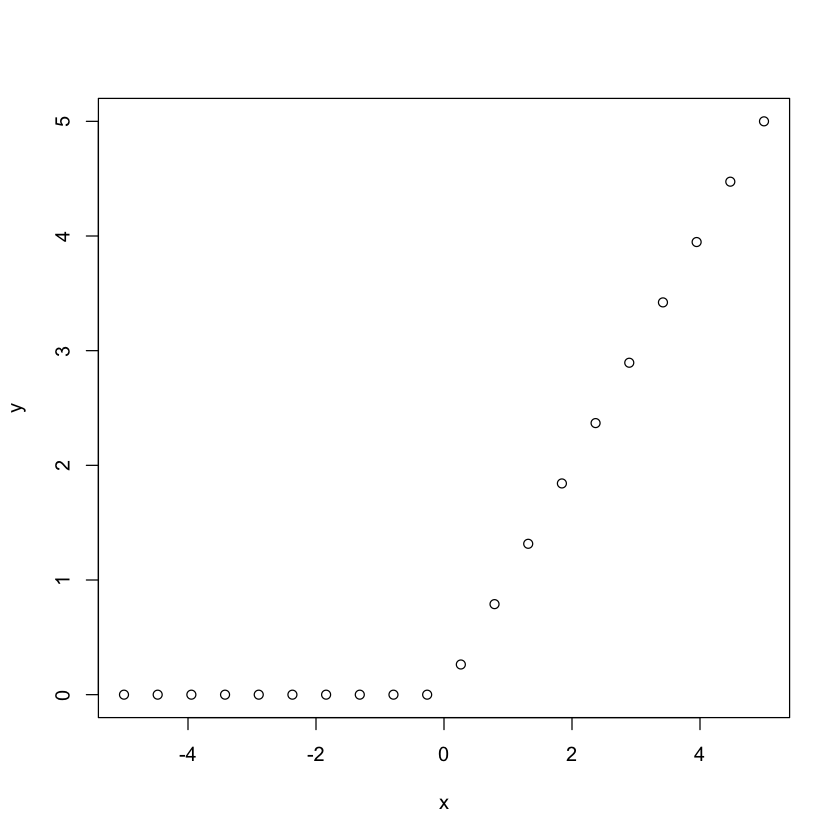

In [10]:
x = seq( from=-5, to=5, length.out = 20 )
y <- torch_relu(x)

# plotting the RELU Activation Function
plot(x, y)

The output layer typically doesn’t have an activation function for regression tasks, while a softmax or sigmoid activation might be used for classification tasks.

### Step 3: Loss Functions

In a neural network, the loss function measures the difference between the model's predictions and the actual target values. For regression tasks, where the goal is to predict continuous values, a common choice for the loss function is Mean Squared Error (MSE). This function calculates the average squared difference between the predicted and actual values, penalizing larger errors more heavily.

### Setting Up the Loss Function

Once the model is defined, we can initialize the loss function. For regression tasks, the MSE loss function is commonly used due to its effectiveness in measuring prediction accuracy for continuous values.

In [11]:
loss_fn <- nn_mse_loss()

# Example batch of predictions (output of model) and true targets
predictions <- torch_tensor(c(2.5, 0.0, 2.1, 1.7))
targets <- torch_tensor(c(3.0, -0.5, 2.0, 1.0))

# Compute loss
loss <- loss_fn(predictions, targets)
print(loss$item())  # Extracts the numeric value of the loss

[1] 0.25


### Step 4: Optimizer

After defining a neural network and a loss function, the next essential component in training a model is the optimizer. An optimizer adjusts the model's parameters based on the calculated gradients to minimize the loss function over time. For this tutorial, we’ll use the Adam optimizer, a popular choice in neural networks because of its efficiency and adaptive learning rate capabilities.

The Adam (Adaptive Moment Estimation) optimizer combines the benefits of two other optimizers—momentum and RMSProp. It adapts the learning rate for each parameter individually based on the first and second moments of the gradients, making it highly effective for a wide range of tasks.

### Setting Up the Adam Optimizer

In torch, we initialize the Adam optimizer using optim_adam. This optimizer requires specifying the model parameters and an initial learning rate.

In [12]:
# Initialize the Adam optimizer
learning_rate <- 0.001
optimizer <- optim_adam(model$parameters, lr = learning_rate)

We now have the complete set of attribute to construct a neural network. In the next section, we discuss the Dataset and DataLoaders

## Dataset and DataLoader

To train a neural network effectively, it’s crucial to manage data efficiently. torch provides Dataset and DataLoaderclasses to streamline data handling, making it easy to work with mini-batches, shuffle data, and perform other preprocessing steps. This is especially helpful when dealing with large datasets, as it allows for more efficient memory and computational management.

### 1. Dataset Class

The Dataset class in torch allows us to create a custom data structure that can load and preprocess data. By defining a custom dataset, we can organize data, apply transformations, and define how to access samples within the dataset.

Here’s an example of creating a simple custom dataset in R for training. We’ll use a basic data structure with length and getitem methods, which define the number of data points and how to access individual samples, respectively.

* initialize: Initializes the dataset with features and labels.
* .getitem: Defines how to access individual samples by index, returning a list containing the feature and label for that index
*.length: Returns the total number of samples in the dataset.

In [13]:
# Define a custom dataset
MyDataset <- dataset(
  initialize = function(features, labels) {
    self$features <- features
    self$labels <- labels
  },
  
  .getitem = function(index) {
    x <- self$features[index, ]
    y <- self$labels[index]
    list(x = x, y = y)
  },
  
  .length = function() {
    self$features$size(1)
  }
)

# Sample data
features <- torch_tensor(matrix(runif(100), nrow = 20, ncol = 5)) # 20 samples, 5 features each
labels <- torch_tensor(runif(20))       # 20 labels

# Initialize the dataset
dataset <- MyDataset(features, labels)
print(dataset$.getitem(1))               # Access the first sample
print(dataset$.length())                 # Number of samples in the dataset

$x
torch_tensor
 0.4931
 0.1567
 0.7699
 0.6386
 0.6420
[ CPUFloatType{5} ]

$y
torch_tensor
0.0697332
[ CPUFloatType{} ]

[1] 20


### 2. DataLoader Class

The DataLoader class is essential for feeding data into the model in manageable batches, a crucial step for efficient neural network training. The DataLoader automatically handles batch creation, data shuffling, and parallel loading if necessary.

To create a DataLoader, specify the dataset, batch size, and whether to shuffle the data.

In [14]:
# Create a DataLoader
batch_size <- 4
data_loader <- dataloader(dataset, batch_size = batch_size, shuffle = TRUE)

coro::loop( for (batch in data_loader) { print(batch); } )

$x
torch_tensor
 0.1657  0.1426  0.0814  0.0796  0.7923
 0.3205  0.6779  0.7026  0.8044  0.9006
 0.6258  0.0206  0.5985  0.0639  0.9900
 0.6212  0.9081  0.3048  0.2386  0.9891
[ CPUFloatType{4,5} ]

$y
torch_tensor
 0.7869
 0.0706
 0.7205
 0.5516
[ CPUFloatType{4} ]

$x
torch_tensor
 0.8175  0.5482  0.4391  0.8712  0.9844
 0.3851  0.7781  0.7126  0.9152  0.8855
 0.4068  0.7150  0.4820  0.5830  0.3185
 0.2917  0.8217  0.0901  0.7057  0.1714
[ CPUFloatType{4,5} ]

$y
torch_tensor
 0.1872
 0.4090
 0.3201
 0.7247
[ CPUFloatType{4} ]

$x
torch_tensor
 0.8311  0.8434  0.7565  0.9086  0.6679
 0.4089  0.3865  0.1458  0.2891  0.0048
 0.6853  0.5315  0.5059  0.0001  0.6631
 0.7080  0.2072  0.2772  0.9740  0.0428
[ CPUFloatType{4,5} ]

$y
torch_tensor
 0.1997
 0.4938
 0.6733
 0.8885
[ CPUFloatType{4} ]

$x
torch_tensor
 0.9782  0.1677  0.4773  0.7375  0.6970
 0.4336  0.2126  0.5757  0.0421  0.9986
 0.7432  0.1747  0.2902  0.8388  0.4903
 0.7410  0.9098  0.2916  0.6076  0.7168
[ CPUFloatType{4,5} 

## Putting It All Together: End-to-End Neural Network Training

Now that we’ve covered the individual components—data preparation, model definition, training and validation functions, loss function, and optimizer—let’s combine everything into a full end-to-end neural network training workflow. This final code snippet brings together data loading, model training, validation, and performance monitoring over multiple epochs.

### Complete Code for Training a Neural Network

The first part of the code defines a simple 3-layer network with an input, hidden and output layer. We also generate a sample data set fit for a regression model. We also created a dataset and dataloader.

In [19]:
#dimensionality of hidden layer
d_in <- 3
d_hidden <- 32
d_out <- 1

# Defining the model
net <- nn_module(
  initialize = function(d_in, d_hidden, d_out) {
    self$net <- nn_sequential(
      nn_linear(d_in, d_hidden),
      nn_relu(),
      nn_linear(d_hidden, d_out)
    )
  },
  forward = function(x) {
    self$net(x)
  }
)

# generating a sample dataset
total_sample <- 1000
x <- torch_randn(total_sample, d_in)
coefs <- c(0.2, -1.3, -0.5)
y <- x$matmul(coefs)$unsqueeze(2) + torch_randn(total_sample, 1)


# Initializing the dataset and dataloader
data_set <- tensor_dataset(x, y)
data_loader <- dataloader(data_set, batch_size = 100, shuffle = TRUE)


The next code-block splits the dataset into a train and test sets using the 80-20 split.

In [20]:
# Split data into train and test sets
train_ids <- sample(1:length(data_set), size = 0.8 * length(data_set)) # 80% for training
test_ids <- setdiff(1:length(data_set), train_ids)                    # Remaining 20% for testing

# Create train and test datasets
train_ds <- dataset_subset(data_set, indices = train_ids)
test_ds <- dataset_subset(data_set, indices = test_ids)

# Create train and test data loaders
train_dl <- dataloader(train_ds, batch_size = 100, shuffle = TRUE)
test_dl <- dataloader(test_ds, batch_size = 100)

### Model Initialization and Hyper-Parameters Setting

Next, we initialize the model and define the relevant hyper-parameter settings.

In [22]:
# initialize model
model <- net(d_in = d_in, d_hidden = d_hidden, d_out = d_out)

# setting up parameter
learning_rate <- 0.001
loss_fn <- nn_mse_loss()
optimizer <- optim_adam(model$parameters, lr = learning_rate)

### Functions for Training and Evaluation of the Model

The next part of the training process, often used to modularize the training and testing process, is to define the training and testing process into function. This simply means to aggregate the parameters update into relevant functions.

In [23]:
train_batch <- function(b) {
  optimizer$zero_grad()                         # Step 1: Clear previous gradients
  output <- model(b[[1]]$to(device = device))   # Step 2: Perform forward pass with input data
  target <- b[[2]]$to(device = device)          # Step 3: Extract and move target labels to the device

  loss <- loss_fn(output, target)               # Step 4: Compute the loss between predictions and targets
  loss$backward()                               # Step 5: Backpropagate gradients
  optimizer$step()                              # Step 6: Update model parameters     

  loss$item()
}

valid_batch <- function(b) {
  output <- model(b[[1]]$to(device = device))
  target <- b[[2]]$to(device = device)

  loss <- loss_fn(output, target)
  loss$item()
}

### Training Process: Epochs and Training

In the training process, we typically set an epoch and train the model based on the number of epochs. For each epoch, we train all the batches in the model. In the example below, we are testing 200 epochs.

In [24]:
train_losses <- c()
valid_losses <- c()

num_epochs <- 200

for (epoch in 1:num_epochs) {
  model$train()
  train_loss <- c()

  # use coro::loop() for stability and performance
  coro::loop(for (b in train_dl) {
    loss <- train_batch(b)
    train_loss <- c(train_loss, loss)
  })
  
  train_losses <- c(train_losses, mean(train_loss))
  cat(sprintf(
    "\nEpoch %d, training: loss: %3.5f",
    epoch, mean(train_loss)
  ))

  model$eval()
  valid_loss <- c()

  # disable gradient tracking to reduce memory usage
  with_no_grad({
    coro::loop(for (b in test_dl) {
      loss <- valid_batch(b)
      valid_loss <- c(valid_loss, loss)
    })
  })

  valid_losses <- c(valid_losses, mean(valid_loss))
  cat(sprintf(
    "\nEpoch %d, validation: loss: %3.5f",
    epoch, mean(valid_loss)
  ))
}


Epoch 1, training: loss: 3.32867
Epoch 1, validation: loss: 3.74048
Epoch 2, training: loss: 3.19454
Epoch 2, validation: loss: 3.60467
Epoch 3, training: loss: 3.06698
Epoch 3, validation: loss: 3.47473
Epoch 4, training: loss: 2.94809
Epoch 4, validation: loss: 3.35240
Epoch 5, training: loss: 2.83081
Epoch 5, validation: loss: 3.23414
Epoch 6, training: loss: 2.71913
Epoch 6, validation: loss: 3.11845
Epoch 7, training: loss: 2.61111
Epoch 7, validation: loss: 3.00388
Epoch 8, training: loss: 2.50609
Epoch 8, validation: loss: 2.89007
Epoch 9, training: loss: 2.40257
Epoch 9, validation: loss: 2.77301
Epoch 10, training: loss: 2.29604
Epoch 10, validation: loss: 2.65833
Epoch 11, training: loss: 2.18769
Epoch 11, validation: loss: 2.54601
Epoch 12, training: loss: 2.08489
Epoch 12, validation: loss: 2.43352
Epoch 13, training: loss: 1.98276
Epoch 13, validation: loss: 2.32029
Epoch 14, training: loss: 1.88175
Epoch 14, validation: loss: 2.21041
Epoch 15, training: loss: 1.78083
Epo

### Visualizing Loss for Training and Test Data

Now we can visualize the loss which have been captured from the training process.

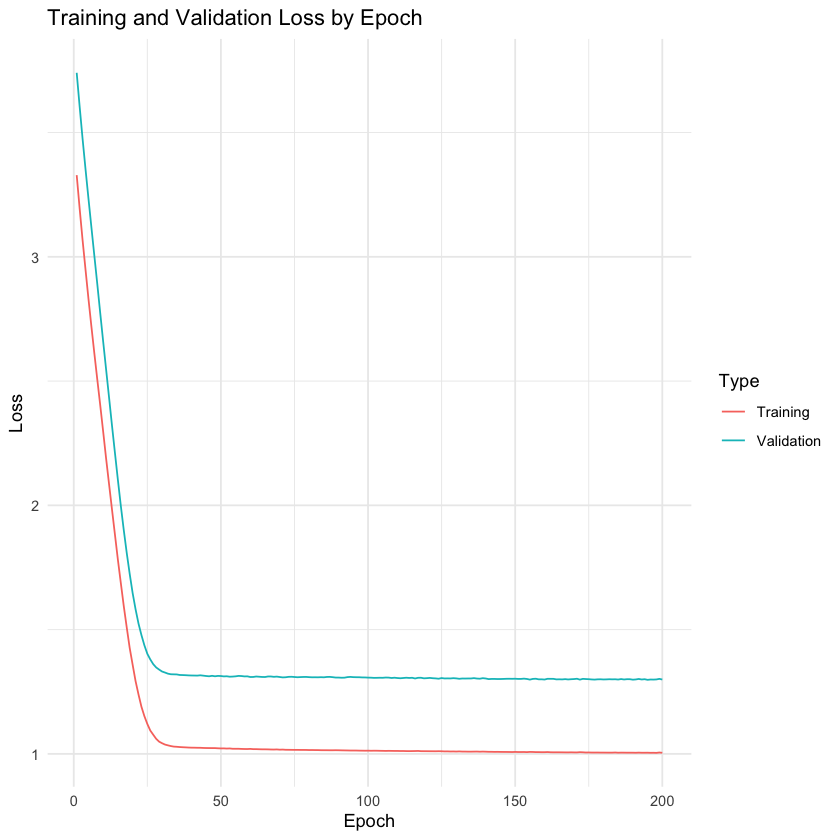

In [25]:
# Convert losses to a data frame for visualization
loss_data <- data.frame(
  Epoch = rep(1:num_epochs, 2),
  Loss = c(train_losses, valid_losses),
  Type = rep(c("Training", "Validation"), each = num_epochs)
)

# Plot using ggplot2
ggplot(loss_data, aes(x = Epoch, y = Loss, color = Type)) +
  geom_line() +
  labs(title = "Training and Validation Loss by Epoch",
       x = "Epoch",
       y = "Loss") +
  theme_minimal()

<br>

## Implementing a More Complex Model Architecture

In the next section, we implement a more complex architecture that includes `drop_out` regularization and a few more layers.

In [26]:
# Second Model
net <- nn_module(
  initialize = function(d_in, d_hidden1, d_hidden2, d_out, dropout_rate = 0.5) {
    self$net <- nn_sequential(
      nn_linear(d_in, d_hidden1),
      nn_relu(),
      nn_dropout(dropout_rate),        # Dropout after first hidden layer
      nn_linear(d_hidden1, d_hidden2), # Second hidden layer
      nn_relu(),
      nn_dropout(dropout_rate),        # Dropout after second hidden layer
      nn_linear(d_hidden2, d_out)      # Output layer
    )
  },
  forward = function(x) {
    self$net(x)
  }
)

# Set up dimensions
d_in <- 3         # Input features
d_hidden1 <- 64   # First hidden layer size
d_hidden2 <- 32   # Second hidden layer size
d_out <- 1        # Output dimension (for regression)


In [27]:
model <- net(d_in = d_in, d_hidden1 = d_hidden1, d_hidden2 = d_hidden2, d_out = d_out, dropout_rate = 0.5)

# setting up parameter
learning_rate <- 0.001
loss_fn <- nn_mse_loss()
optimizer <- optim_adam(model$parameters, lr = learning_rate)

In [28]:
train_losses <- c()
valid_losses <- c()

num_epochs <- 200

for (epoch in 1:num_epochs) {
  model$train()
  train_loss <- c()

  # use coro::loop() for stability and performance
  coro::loop(for (b in train_dl) {
    loss <- train_batch(b)
    train_loss <- c(train_loss, loss)
  })
  
  train_losses <- c(train_losses, mean(train_loss))
  cat(sprintf(
    "\nEpoch %d, training: loss: %3.5f",
    epoch, mean(train_loss)
  ))

  model$eval()
  valid_loss <- c()

  # disable gradient tracking to reduce memory usage
  with_no_grad({
    coro::loop(for (b in test_dl) {
      loss <- valid_batch(b)
      valid_loss <- c(valid_loss, loss)
    })
  })

  valid_losses <- c(valid_losses, mean(valid_loss))
  cat(sprintf(
    "\nEpoch %d, validation: loss: %3.5f",
    epoch, mean(valid_loss)
  ))
}


Epoch 1, training: loss: 2.91626
Epoch 1, validation: loss: 3.20046
Epoch 2, training: loss: 2.72918
Epoch 2, validation: loss: 2.92810
Epoch 3, training: loss: 2.52399
Epoch 3, validation: loss: 2.65445
Epoch 4, training: loss: 2.30827
Epoch 4, validation: loss: 2.37228
Epoch 5, training: loss: 2.01589
Epoch 5, validation: loss: 2.08625
Epoch 6, training: loss: 1.90024
Epoch 6, validation: loss: 1.83845
Epoch 7, training: loss: 1.60985
Epoch 7, validation: loss: 1.63800
Epoch 8, training: loss: 1.56036
Epoch 8, validation: loss: 1.50505
Epoch 9, training: loss: 1.48026
Epoch 9, validation: loss: 1.45589
Epoch 10, training: loss: 1.54466
Epoch 10, validation: loss: 1.44219
Epoch 11, training: loss: 1.48812
Epoch 11, validation: loss: 1.41315
Epoch 12, training: loss: 1.50896
Epoch 12, validation: loss: 1.38881
Epoch 13, training: loss: 1.34470
Epoch 13, validation: loss: 1.38656
Epoch 14, training: loss: 1.45571
Epoch 14, validation: loss: 1.37826
Epoch 15, training: loss: 1.30884
Epo

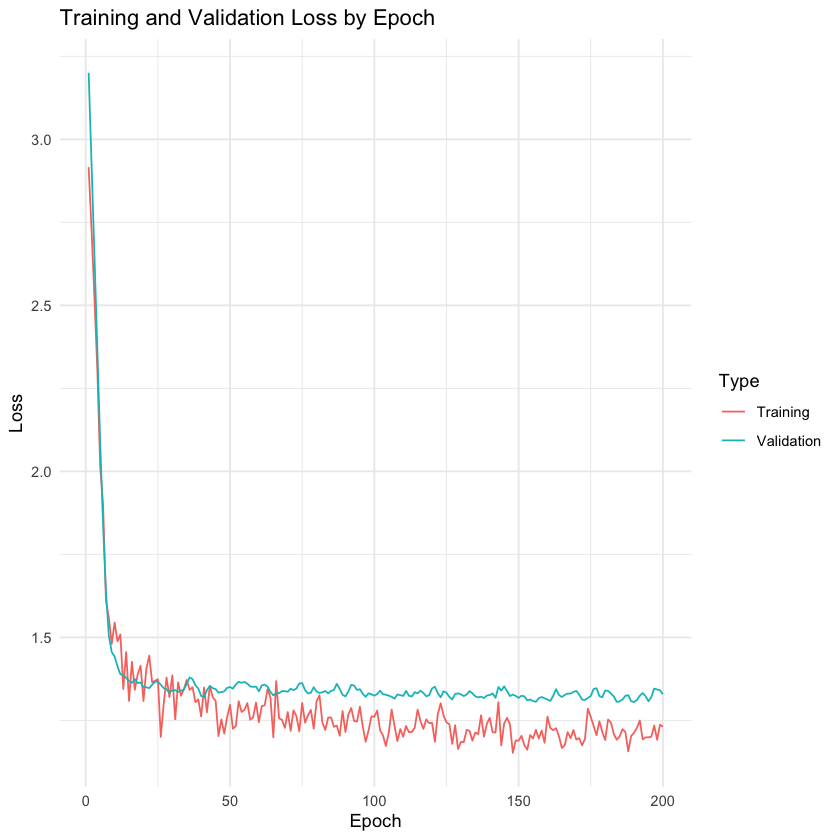

In [29]:
# Convert losses to a data frame for visualization
loss_data <- data.frame(
  Epoch = rep(1:num_epochs, 2),
  Loss = c(train_losses, valid_losses),
  Type = rep(c("Training", "Validation"), each = num_epochs)
)

# Plot using ggplot2
ggplot(loss_data, aes(x = Epoch, y = Loss, color = Type)) +
  geom_line() +
  labs(title = "Training and Validation Loss by Epoch",
       x = "Epoch",
       y = "Loss") +
  theme_minimal()